# Explore luminosity (without K-corrections) combinations

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

Previously, we have selected features which can add the most information  
to the analysis. Now, we want to find ways to mixture the features to obtain  
possible correlations among our data.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import getpass
import progressbar
import pandas as pd
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux_radio(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

In [6]:
def lum_from_flux(flux, redshift):  # Flux in mJy, general version, without K-correction
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26  # in W/Hz
    return luminosity

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [7]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [8]:
cmap           = cm.get_cmap('inferno')
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [9]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Function to create scatter plot of quotients of features vs redshift.

In [10]:
def plot_scatter_quotient(quot, col_a, col_b, ax1, filter_finite):
    # Randomize order of elements to plot
    indices = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    scatter_out  = ax1.scatter(redshift_df[filter_finite].values[indices], quot[filter_finite].values[indices],\
                               c=origin_df[filter_finite].values[indices], alpha=0.80, marker='o',\
                               s=85, cmap='Dark2', edgecolor='k', linewidths=0.5)
    
    col_a_label  = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}}'
    col_b_label  = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}}'
    
    axis_label   = f'${col_a_label} / {col_b_label}$'
    
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
    ax1.set_xlabel('redshift', size=14)
    # ax1.set_ylabel('quotient', size=14)
    ax1.set_ylabel(axis_label, size=14)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    # produce a legend with the unique colors from the scatter
    classes = [origin_labels[flag] for flag in np.unique(origin_df[filter_finite])]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    plt.legend(handles=scatter_out.legend_elements()[0], labels=classes, markerscale=2, edgecolor='k', prop={'size': 11})

Function to create scatter plots of features showing their origin (survey)  
and not the redshift values.

In [11]:
def plot_scatter_origin(col_a, col_b, ax1, filter_finite, use_rescaled=False):
    if not use_rescaled:
        array_a       = large_catalog_df[col_a][filter_finite]
        array_b       = large_catalog_df[col_b][filter_finite]
    if use_rescaled:
        array_a       = norm_large_catalog_df[col_a][filter_finite]
        array_b       = norm_large_catalog_df[col_b][filter_finite]
    
    min_val       = np.nanmin([array_a.min(), array_b.min()])
    max_val       = np.nanmax([array_a.max(), array_b.max()])
    
    # Add 1-1 line and parallels for comparison
    ax1.plot([min_val*0.7, max_val*1.3], [min_val*0.7, max_val*1.3], ls='dashed', color='k', alpha=0.45, lw=1)
    for factor in [1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16]:  # [1e3, 1e6, 1e9, 1e12]
        ax1.plot([min_val*0.7, max_val], [min_val*factor*0.7, max_val*factor], ls='dashed', color='k', alpha=0.45, lw=1)
        ax1.plot([min_val*0.7, max_val*factor], [min_val/factor*0.7, max_val], ls='dashed', color='k', alpha=0.45, lw=1)
    
    # Randomize order of elements to plot
    indices = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    scatter_out  = ax1.scatter(array_a.values[indices], array_b.values[indices],\
                               c=origin_df[filter_finite].values[indices], alpha=0.80, marker='o', s=85, cmap='Dark2',\
                               edgecolor='k', linewidths=0.5)
    
    col_a_label  = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}}'
    col_b_label  = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}}'
    
    if not use_rescaled:
        axis_a_label   = f'${col_a_label}  \, [W/Hz]$'
        axis_b_label   = f'${col_b_label}  \, [W/Hz]$'
    if use_rescaled:
        axis_a_label   = f'${col_a_label}  \, [Normalized Units]$'
        axis_b_label   = f'${col_b_label}  \, [Normalized Units]$'
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim(min_val*0.7, max_val*1.3)
    ax1.set_xlim(min_val*0.7, max_val*1.3)
    # ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
    ax1.set_xlabel(axis_a_label, size=14)
    # ax1.set_ylabel('quotient', size=14)
    ax1.set_ylabel(axis_b_label, size=14)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    # produce a legend with the unique colors from the scatter
    classes = [origin_labels[flag] for flag in np.unique(origin_df[filter_finite])]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    plt.legend(handles=scatter_out.legend_elements()[0], labels=classes, markerscale=2, edgecolor='k', prop={'size': 11}, loc=0)

Function to create scatter plots with histograms for features.

In [12]:
def plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, plot_hst_flg=True, use_rescaled=False):
    # Obtain luminosities and the cross-match between them
    if not use_rescaled:
        lum_a       = large_catalog_df[col_a]
        lum_b       = large_catalog_df[col_b]
    if use_rescaled:
        lum_a       = norm_large_catalog_df[col_a]
        lum_b       = norm_large_catalog_df[col_b]
    common_vals     = np.multiply(lum_a, lum_b)
    filter_finite   = np.isfinite(common_vals) & np.array(common_vals > 0)
    if np.sum(filter_finite) == 0: return 'No elements to plot'
    
    # Create log bins for log-scale histograms
    min_val         = np.nanmin([lum_a[filter_finite].min(), lum_b[filter_finite].min()])
    max_val         = np.nanmax([lum_a[filter_finite].max(), lum_b[filter_finite].max()])
    bins_a          = np.logspace(np.log10(lum_a[filter_finite].values.min()), np.log10(lum_a[filter_finite].values.max()), 30)
    bins_b          = np.logspace(np.log10(lum_b[filter_finite].values.min()), np.log10(lum_b[filter_finite].values.max()), 30)
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    # Format axis names and limits
    if not use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{W/Hz}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{W/Hz}]'
    if use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
    axis_a_label    = f'${col_a_label}$'
    axis_b_label    = f'${col_b_label}$'
        
    ax1.set_xlabel(axis_a_label, size=14)
    ax1.set_ylabel(axis_b_label, size=14)
    ax1.set_ylim(min_val*0.7, max_val*1.3)
    ax1.set_xlim(min_val*0.7, max_val*1.3)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    # Add 1-1 line and parallels for comparison
    ax1.plot([min_val*0.7, max_val*1.3], [min_val*0.7, max_val*1.3], ls='dashed', color='k', alpha=0.45, lw=1)
    for factor in [1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16]:  # [1e3, 1e6, 1e9, 1e12]
        ax1.plot([min_val*0.7, max_val], [min_val*factor*0.7, max_val*factor], ls='dashed', color='k', alpha=0.45, lw=1)
        ax1.plot([min_val*0.7, max_val*factor], [min_val/factor*0.7, max_val], ls='dashed', color='k', alpha=0.45, lw=1)
    
    # Randomize order of elements to plot
    indices         = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    sc_plot         = ax1.scatter(lum_a[filter_finite].values[indices], lum_b[filter_finite].values[indices],\
                                 c=redshift_df[filter_finite].values[indices], cmap='inferno_r',\
                                 s=(origin_df[filter_finite].values[indices] + 2)**4, alpha=0.80, edgecolor='k')  # s=30
    
    # Create colorbar and plot it
    cbaxes          = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
    clb             = plt.colorbar(sc_plot, cax=cbaxes, orientation='horizontal')
    clb.ax.tick_params(labelsize=12) 
    # clb.set_label('redshift', size=14)
    clb.ax.set_title('redshift', size=14)
    
    # produce a legend with the unique colors from the scatter
    classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2)**4]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    ax1.legend(handles=sc_plot.legend_elements(prop='sizes')[0], labels=classes, loc=0, prop={'size': 14},  edgecolor='k')
    
    ax1.set_aspect('auto', share=False, adjustable='box')
    
    if add_histograms_flag:
        # Plot vertical histogram
        hist(lum_b[filter_finite].values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('N', size=14)
        
        # Plot horizontal histogram
        hist(lum_a[filter_finite].values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.set_ylabel('N', size=14)
        
        # Modify ticks
        ax2.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
        ax3.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
        plt.setp(ax2.get_yticklabels(), visible=False)
        plt.setp(ax3.get_xticklabels(), visible=False)
        plt.setp(ax2.spines.values(), linewidth=2.5)
        plt.setp(ax3.spines.values(), linewidth=2.5)
        ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
        ax3.tick_params(which='both',top=True, right=True, direction='in')
        
        plt.subplots_adjust(wspace=0.0, hspace=0.0)

Function to plot SED points for individual sources.

In [13]:
def plot_sed_source(source_idx, source_z, ax1):
    # Obtain rest-frame frequencies and luminosities
    freq_values_restframe = np.array(freq_values) * (1 + source_z)
    data_lums             = large_catalog_df.iloc[source_idx]
    
    # Order by frequency to tidy plot up
    order_freq            = np.argsort(np.array(freq_values))
    used_lum_f            = np.array(data_lums[order_freq] > 0)
    lums                  = data_lums[order_freq][used_lum_f]
    freqs_obs             = np.array(freq_values)[order_freq][used_lum_f]
    freqs_rest            = freq_values_restframe[order_freq][used_lum_f]
    
    # Plot luminosities with observed frequencies
    ax1.plot(freqs_obs, lums, 'o-', ms=17, color=colors[3], mec='k', mew=1.5)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # Add new axis for rest-frame frequencies
    ax2                   = ax1.twiny()
    y1, y2                = ax1.get_xlim()
    ax2.set_xlim(y1*(1 + source_z), y2*(1 + source_z))
    ax2.set_xscale('log')
    
    # Check for source name, if any
    if type(orig_names.iloc[source_idx]) == str:
        source_name = orig_names.iloc[source_idx]
    elif type(newer_names.iloc[source_idx]) == str:
        source_name = orig_names.iloc[source_idx]
    else:
        source_name = 'No known name'
    
    # Add textbox with source properties
    textstr = '\n'.join((
    'id: = %i' % (large_catalog_df.index[source_idx], ),
    '%s' % (source_name, ),
    'z = %.2f' % (source_z, ),
    '%s' % (coords_arr.iloc[source_idx].to_string('hmsdms'), )))
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='w', alpha=0.5)
    
    # place a text box in upper left in axes coords
    ax1.text(0.5, 0.15, textstr, transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props, ha='center', weight='heavy')
    
    # Customizations
    ax1.set_xlabel('Observed Frequency [Hz]', size=14)
    ax1.set_ylabel('Luminosity [W/Hz]', size=14)
    ax2.set_xlabel('Rest-frame Frequency [Hz]', size=14)
    ax1.tick_params(which='both', top=False, right=True,  direction='in')
    ax2.tick_params(which='both', top=True, bottom=False, right=False, left=False, direction='in')
    ax1.tick_params(which='major', length=8, width=1.5)
    ax2.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax2.tick_params(which='minor', length=4, width=1.5)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    plt.setp(ax2.spines.values(), linewidth=2.5)

---

## Reading data

In [14]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

We separate our data in luminosities and redshift values (column name `z_value`).

It is important to keep in mind that columns with luminosity values start their names with `Luminosity...`  
and they are in `W / Hz`.  

Uncertainties have not been included up to this point. They are included (as flux uncertainties in the file `large_cat_simbad_inayoshi_ned.h5`).

In [15]:
# large_catalog_df = pd.read_hdf(cat_path + 'large_cat_lums_z_clean_jun2020.h5', 'df').drop(columns=['z_val', 'origin'])
# redshift_df      = pd.read_hdf(cat_path + 'large_cat_lums_z_clean_jun2020.h5', 'df')['z_val']
# origin_df        = pd.read_hdf(cat_path + 'large_cat_lums_z_clean_jun2020.h5', 'df')['origin']  # 0:SDSS+FIRST, 1:COSMOS, 2:RADIO, 3:Inayoshi

In [16]:
file_name        = 'large_cat_flux_z_clean_jun2020.h5'

In [17]:
flux_catalog_df  = pd.read_hdf(cat_path + file_name, 'df').drop(columns=['z_val', 'origin'])
redshift_df      = pd.read_hdf(cat_path + file_name, 'df')['z_val']
origin_df        = pd.read_hdf(cat_path + file_name, 'df')['origin']  # 0:SDSS+FIRST, 1:COSMOS, 2:RADIO, 3:Stripe82, 4:Inayoshi

Since data from `RADIO` come from different sources, we will not use those sources for our calculations  
(it is a compilation of elements).

In [18]:
mask_origin      = np.array(origin_df == 0) + np.array(origin_df == 1) + np.array(origin_df == 3) + np.array(origin_df == 4)
flux_catalog_df  = flux_catalog_df.loc[mask_origin]
redshift_df      = redshift_df.loc[mask_origin]
origin_df        = origin_df.loc[mask_origin]

Data could be also converted into `astropy` Tables.

In [19]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [20]:
# np.savetxt(cat_path + 'column_names_flux.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

Missing values have been replaced with the number $-99.0$ which, in the context of our dataset,  
is a very unlikely quantity to be found.

If needed (not for the moment) these values can be masked and treated as proper missing values.

In [21]:
flux_catalog_df[flux_catalog_df == -99.0]  = None
flux_catalog_df[flux_catalog_df <=  00.0]  = None

In [22]:
counts_df        = flux_catalog_df.notnull().sum(axis=1)  # Count the number of entries per source

We, now, can convert these fluxes into luminosities.  
In this case, we have not applied K-correction factors of any kind.  
Thus, these luminosities are useful for comparison purposes only.

In [23]:
large_catalog_df = flux_catalog_df.apply(lum_from_flux, args=[redshift_df])

In [24]:
large_catalog_df[large_catalog_df == -99.0] = None
large_catalog_df[large_catalog_df <=  00.0] = None

In [25]:
large_catalog_df.columns = large_catalog_df.columns.str.replace('Flux', 'Luminosity')

Since we will explore, mostly, graphically our data, it is possible  
to rescale our dataset to values between $0$ and $1$.

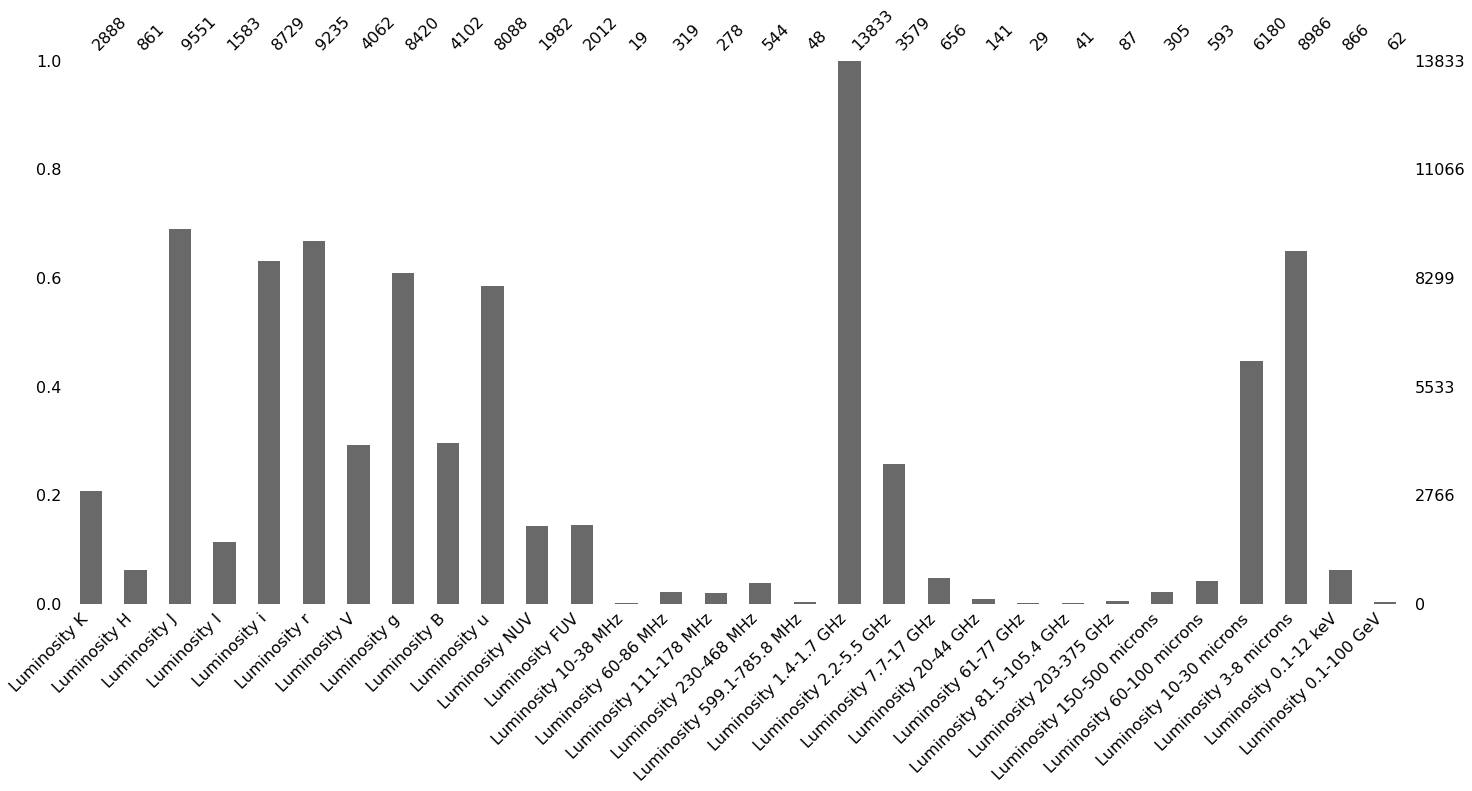

In [26]:
msno.bar(large_catalog_df)

In [27]:
min_max_scaler        = preprocessing.MaxAbsScaler()
x_scaled              = min_max_scaler.fit_transform(large_catalog_df.values)
norm_large_catalog_df = pd.DataFrame(data=x_scaled,\
                                columns=large_catalog_df.columns) 

We can also load previously derived properties for sources, such as  
position, names, etc.

In [28]:
extra_file_name  = 'large_cat_simbad_inayoshi_ned_jun2020.h5'

In [29]:
# extra_catalog_df = pd.read_hdf(cat_path + extra_file_name, 'df')
coord_ra_deg     = pd.read_hdf(cat_path + extra_file_name, 'df')['RA_d']
coord_dec_deg    = pd.read_hdf(cat_path + extra_file_name, 'df')['DEC_d']
orig_names       = pd.read_hdf(cat_path + extra_file_name, 'df')['MAIN_ID_x']
newer_names      = pd.read_hdf(cat_path + extra_file_name, 'df')['MAIN_ID_y']

In [30]:
coords_arr       = pd.Series(SkyCoord(coord_ra_deg, coord_dec_deg, unit=u.degree), index=coord_ra_deg.index)

In [31]:
coord_ra_deg     = coord_ra_deg[mask_origin]
coord_dec_deg    = coord_dec_deg[mask_origin]
orig_names       = orig_names[mask_origin]   # From original source or SIMBAD
ned_names        = newer_names[mask_origin]  # From NED
coords_arr       = coords_arr[mask_origin]

---

In [32]:
large_catalog_df.columns

Index(['Luminosity K', 'Luminosity H', 'Luminosity J', 'Luminosity I',
       'Luminosity i', 'Luminosity r', 'Luminosity V', 'Luminosity g',
       'Luminosity B', 'Luminosity u', 'Luminosity NUV', 'Luminosity FUV',
       'Luminosity 10-38 MHz', 'Luminosity 60-86 MHz',
       'Luminosity 111-178 MHz', 'Luminosity 230-468 MHz',
       'Luminosity 599.1-785.8 MHz', 'Luminosity 1.4-1.7 GHz',
       'Luminosity 2.2-5.5 GHz', 'Luminosity 7.7-17 GHz',
       'Luminosity 20-44 GHz', 'Luminosity 61-77 GHz',
       'Luminosity 81.5-105.4 GHz', 'Luminosity 203-375 GHz',
       'Luminosity 150-500 microns', 'Luminosity 60-100 microns',
       'Luminosity 10-30 microns', 'Luminosity 3-8 microns',
       'Luminosity 0.1-12 keV', 'Luminosity 0.1-100 GeV'],
      dtype='object')

Define frequencies of previous bands for calculating luminosities.

In [33]:
bands_freqs = {}
# freq_values = [1.36e14, 1.82e14, 2.40e14, 2.90e14, 3.50e14, 3.90e14, 4.70e14,\
#                5.42e14, 6.17e14, 6.90e14, 8.36e14, 1.30e15, 1.95e15,\
#                1.00e07, 7.00e07, 1.50e08,\
#                3.00e08, 6.00e08, 1.40e09,\
#                3.00e09, 1.00e10, 3.00e10,\
#                7.00e10, 1.00e11, 3.00e11,\
#                8.57e11, 3.00e12, 1.20e13,\
#                7.00e13, 9.00e17, 1.00e25]  # Hz
freq_values = [1.36e14, 1.82e14, 2.40e14, 3.50e14,\
               3.90e14, 4.70e14, 5.42e14, 6.17e14,\
               6.90e14, 8.36e14, 1.30e15, 1.95e15,\
               1.00e07, 7.00e07,\
               1.50e08, 3.00e08,\
               6.00e08, 1.40e09,\
               3.00e09, 1.00e10,\
               3.00e10, 7.00e10,\
               1.00e11, 3.00e11,\
               8.57e11, 3.00e12,\
               1.20e13, 7.00e13,\
               9.00e17, 1.00e25]  # Hz
for band_name, freq in zip(large_catalog_df.columns, freq_values):
    bands_freqs[band_name] = freq

---

# Plot quotients of features as function of z

We can explore, individually, the quotients between pairs of features (luminosities).

In [34]:
origin_labels = {0:'FIRST', 1:'COSMOS', 2:'RADIO', 3:'Stripe82', 4:'Inayoshi'}

In [35]:
col_a_q         = 'Luminosity I'
col_b_q         = 'Luminosity NUV'
quot            = large_catalog_df[col_a_q] / large_catalog_df[col_b_q]
filter_finite_q = np.isfinite(quot)

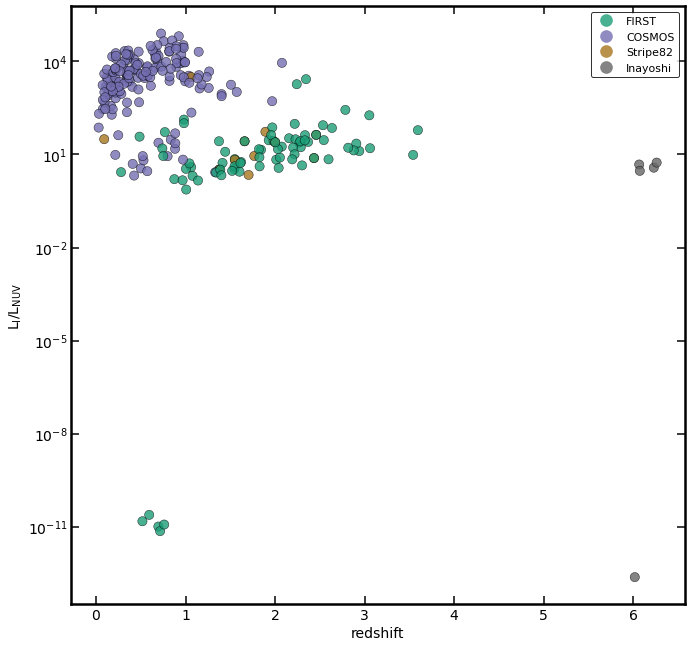

In [36]:
fig             = plt.figure(figsize=(11,11))
ax1             = fig.add_subplot(111)

plot_scatter_quotient(quot, col_a_q, col_b_q, ax1, filter_finite_q)

---

# Plot pairs of features and highlight their origin

We can also plot comparisons between features looking for eventual correlations.

In [37]:
col_a_s         = 'Luminosity 2.2-5.5 GHz'
col_b_s         = 'Luminosity 1.4-1.7 GHz'
common_vals_s   = np.multiply(large_catalog_df[col_a_s], large_catalog_df[col_b_s])
filter_finite_s = np.isfinite(common_vals_s)

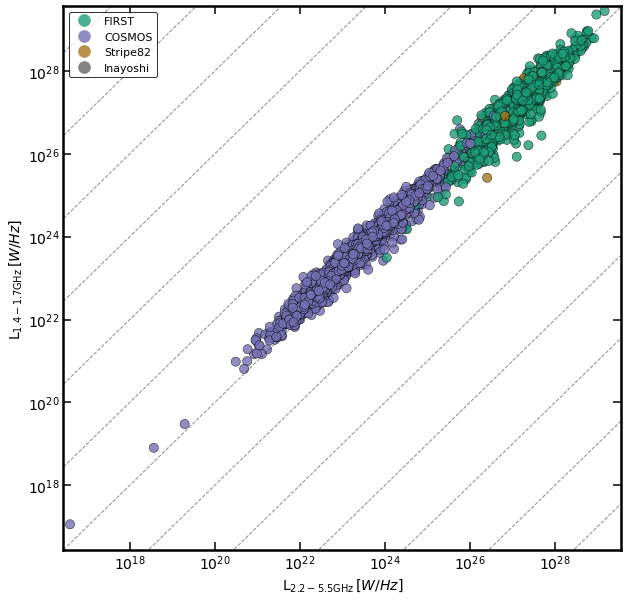

In [38]:
fig             = plt.figure(figsize=(10,10))
ax1             = fig.add_subplot(111)

plot_scatter_origin(col_a_s, col_b_s, ax1, filter_finite_s)

---

# Plot pairs of features with high correlation

The pairs of features with the highest absolute correlations are  
shown in the following table.

|Feature 1                   |Feature 2                     |abs(cor)|
|:---------------------------|:-----------------------------|--------|
|Luminosity 1.4-1.7 GHz      |Luminosity 7.7-163.1 GHz      |0.893468|
|Luminosity 10-100 microns   |Luminosity 3-8 microns        |0.884450|
|Luminosity g                |Luminosity NUV                |0.880781|
|Luminosity J                |Luminosity r                  |0.880339|
|Luminosity H                |Luminosity 10-100 microns     |0.878460|
|Luminosity 3-8 microns      |Luminosity 0.1-195 keV        |0.873482|
|Luminosity 1.4-1.7 GHz      |Luminosity 3-8 microns        |0.872294|
|Luminosity Y                |Luminosity 3-8 microns        |0.867947|
|Luminosity NUV              |Luminosity 3-8 microns        |0.865959|
|Luminosity H                |Luminosity 0.1-195 keV        |0.862878|
|                            |Luminosity 2.2-5.5 GHz        |0.862617|
|Luminosity FUV              |Luminosity 3-8 microns        |0.860816|
|Luminosity B                |Luminosity 150-500 microns    |0.860405|
|Luminosity g                |Luminosity 3-8 microns        |0.853563|
|Luminosity NUV              |Luminosity 2.2-5.5 GHz        |0.852456|
|Luminosity g                |Luminosity FUV                |0.851834|
|Luminosity V                |Luminosity 150-500 microns    |0.847887|
|Luminosity I                |Luminosity r                  |0.844780|
|Luminosity NUV              |Luminosity 0.1-195 keV        |0.843666|
|Luminosity 2.2-5.5 GHz      |Luminosity 3-8 microns        |0.843112|
|Luminosity K                |Luminosity 150-500 microns    |0.841183|
|Luminosity 1.4-1.7 GHz      |Luminosity 0.1-100 GeV        |0.839007|
|Luminosity g                |Luminosity u                  |0.837763|
|Luminosity 1.4-1.7 GHz      |Luminosity 0.1-195 keV        |0.835894|
|Luminosity I                |Luminosity 2.2-5.5 GHz        |0.826631|
|Luminosity H                |Luminosity V                  |0.826213|
|Luminosity 150-500 microns  |Luminosity 3-8 microns        |0.825118|
|Luminosity NUV              |Luminosity FUV                |0.824937|
|Luminosity 2.2-5.5 GHz      |Luminosity 0.1-100 GeV        |0.824597|
|Luminosity 2.2-5.5 GHz      |Luminosity 0.1-195 keV        |0.814032|
|Luminosity g                |Luminosity 0.1-195 keV        |0.810993|
|Luminosity I                |Luminosity 1.4-1.7 GHz        |0.810941|
|Luminosity H                |Luminosity B                  |0.809663|
|Luminosity FUV              |Luminosity 0.1-195 keV        |0.809505|
|Luminosity H                |Luminosity I                  |0.808196|
|Luminosity 150-500 microns  |Luminosity 0.1-195 keV        |0.806506|
|                            |Luminosity 10-100 microns     |0.803695|
|Luminosity V                |Luminosity 2.2-5.5 GHz        |0.803239|
|Luminosity H                |Luminosity 0.1-100 GeV        |0.802956|
|Luminosity 203-375 GHz      |Luminosity 0.1-195 keV        |0.800100|
|Luminosity FUV              |Luminosity 10-100 microns     |0.799202|
|Luminosity g                |Luminosity 10-100 microns     |0.798796|
|Luminosity 1.4-1.7 GHz      |Luminosity 10-100 microns     |0.798157|
|Luminosity FUV              |Luminosity 2.2-5.5 GHz        |0.796445|
|Luminosity NUV              |Luminosity 10-100 microns     |0.795705||

These pairs will be used to produce scatter plots.

The size of the markers (points) indicates the origin of the source (i.e., the survey they come from).  
The surveys have been described in the beginning of this notebook.

In [39]:
orig_label_mod = {(0 + 2)**4:'FIRST+SDSS', (1 + 2)**4:'COSMOS+VLA', (2 + 2)**4:'RADIO', (3 + 2)**4:'Stripe82', (4 + 2)**4:'Inayoshi (z>5.5)'}

In [40]:
lum_names           = large_catalog_df.columns

In [41]:
add_histograms_flag = True  # Add histograms to the folowing plot

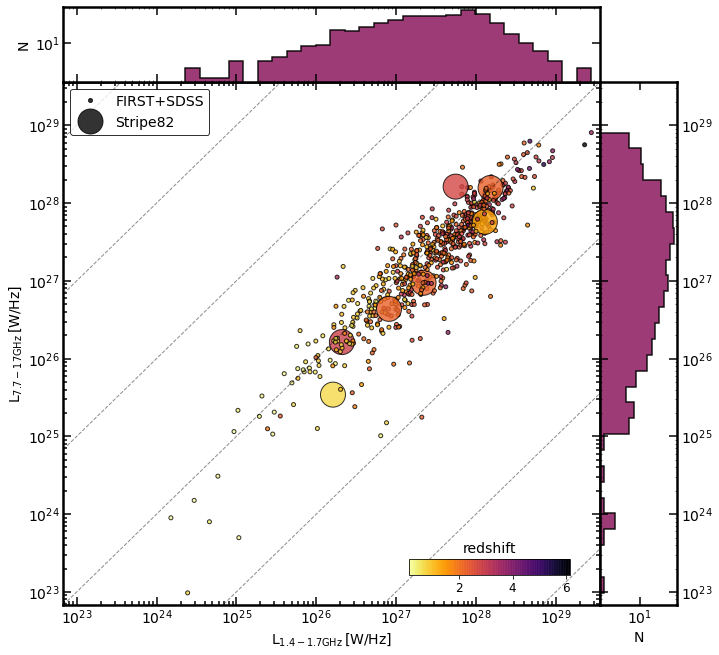

In [42]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by number
# col_a = lum_names[0]
# col_b = lum_names[23]

# Select columns by name
col_a         = "Luminosity 1.4-1.7 GHz"
col_b         = "Luminosity 7.7-17 GHz"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

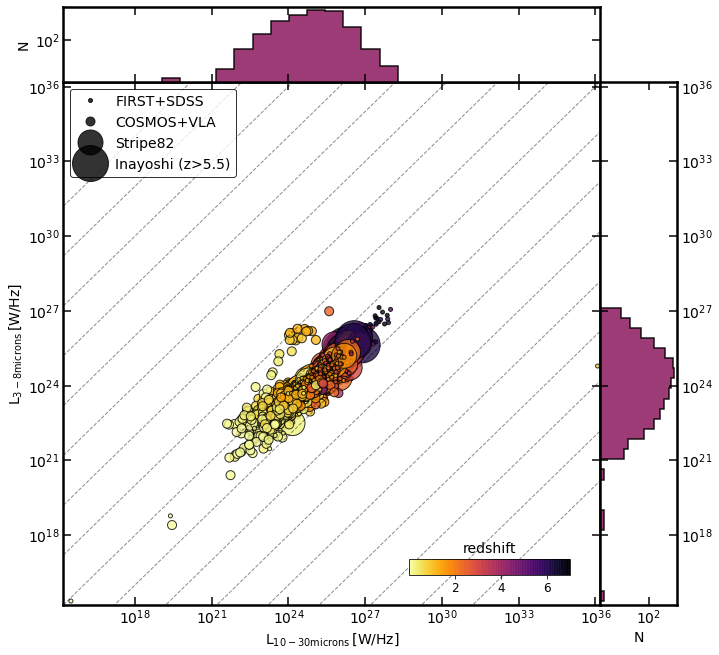

In [43]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity 10-30 microns"
col_b         = "Luminosity 3-8 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

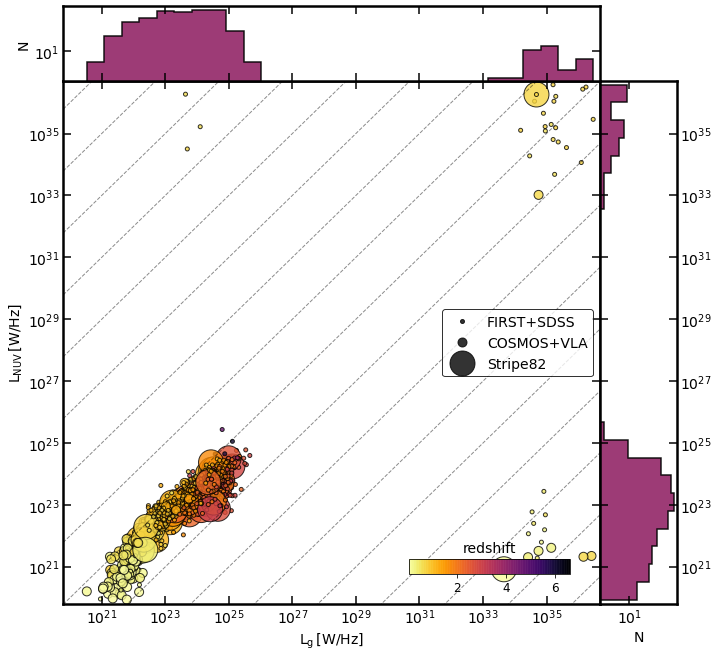

In [44]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity g"
col_b         = "Luminosity NUV"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

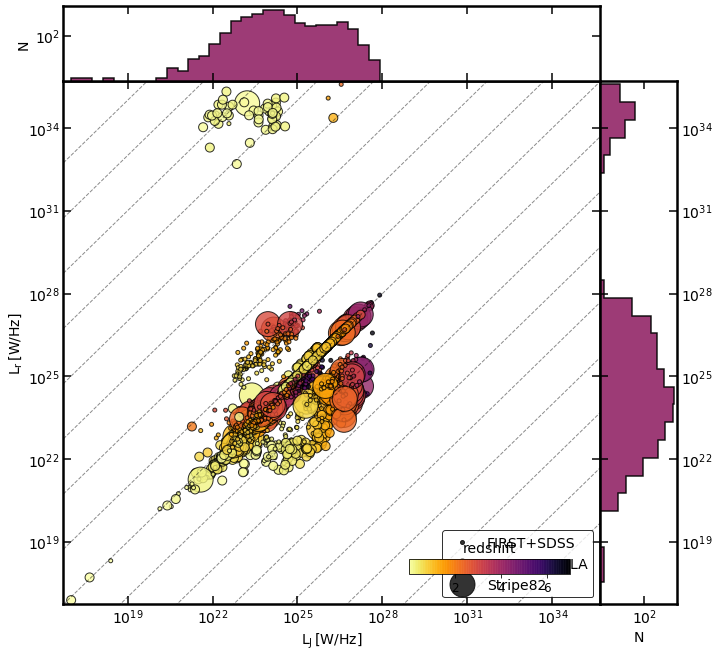

In [45]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity J"
col_b         = "Luminosity r"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

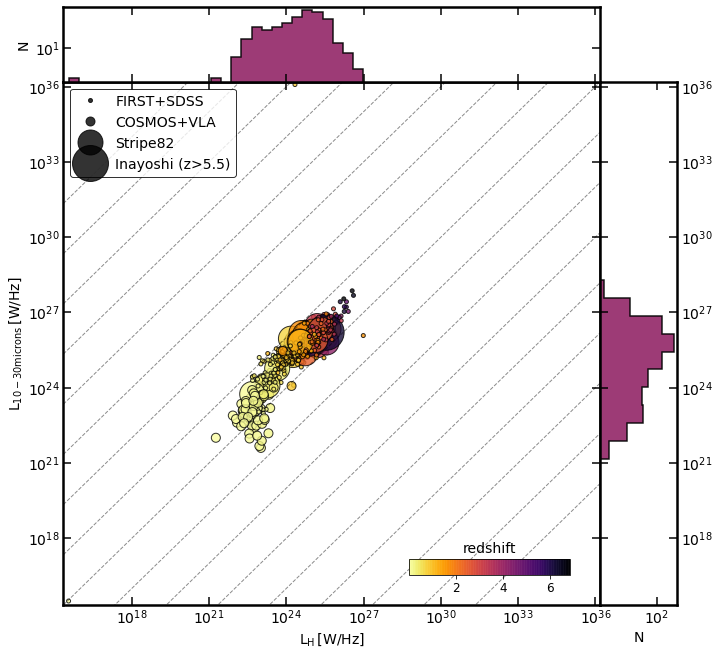

In [46]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity H"
col_b         = "Luminosity 10-30 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

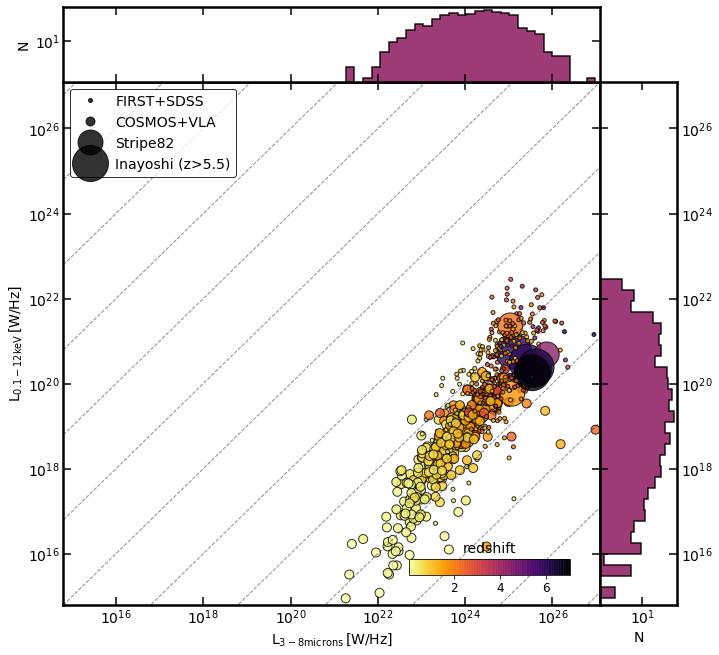

In [47]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity 3-8 microns"
col_b         = "Luminosity 0.1-12 keV"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

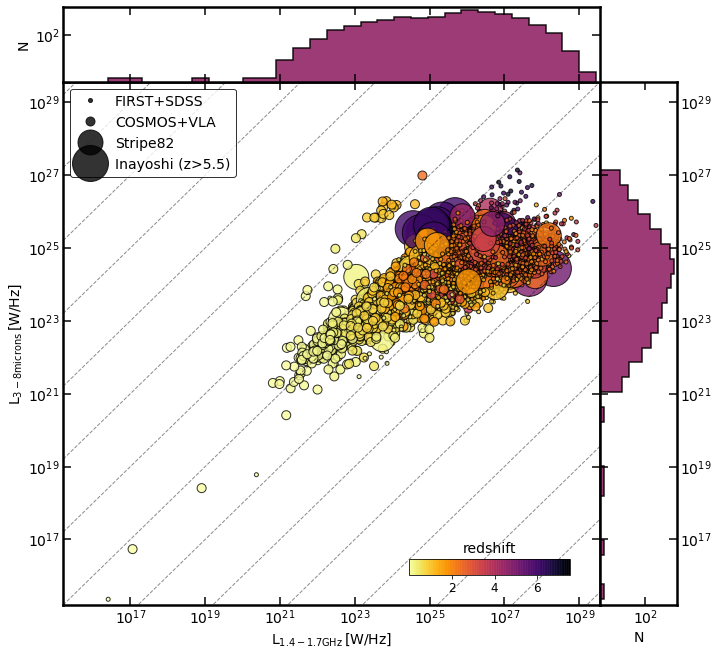

In [48]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity 1.4-1.7 GHz"
col_b         = "Luminosity 3-8 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

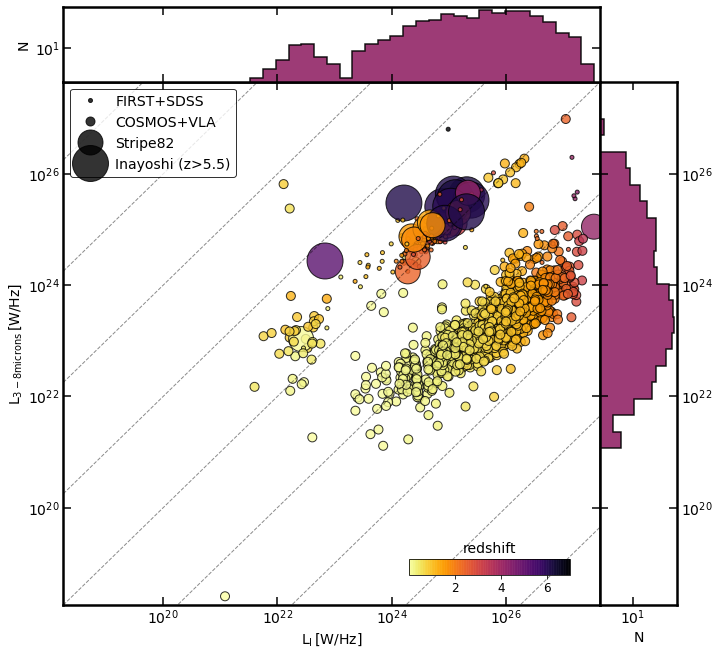

In [49]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity I"
col_b         = "Luminosity 3-8 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

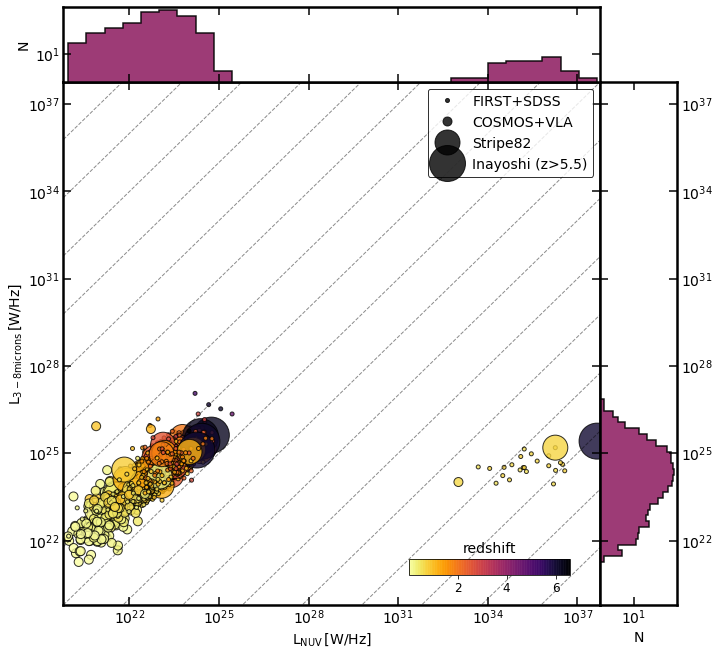

In [50]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity NUV"
col_b         = "Luminosity 3-8 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

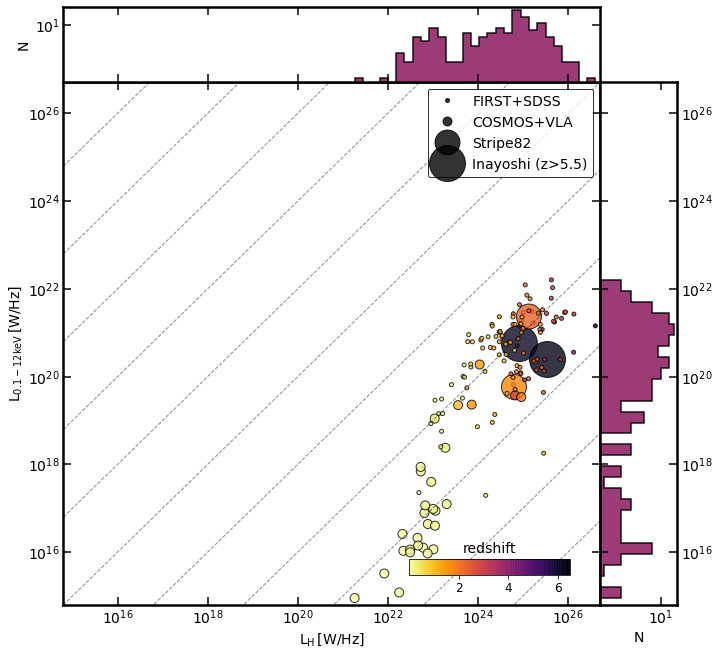

In [51]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity H"
col_b         = "Luminosity 0.1-12 keV"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

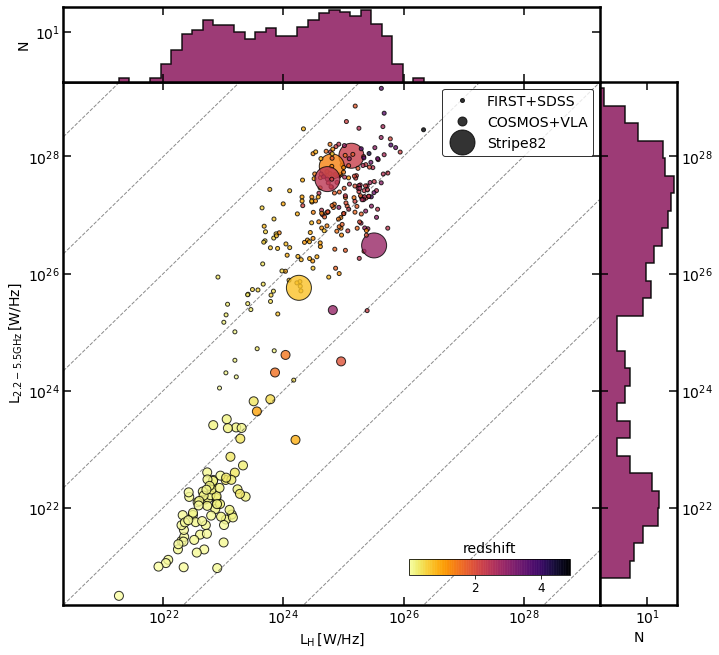

In [52]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity H"
col_b         = "Luminosity 2.2-5.5 GHz"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

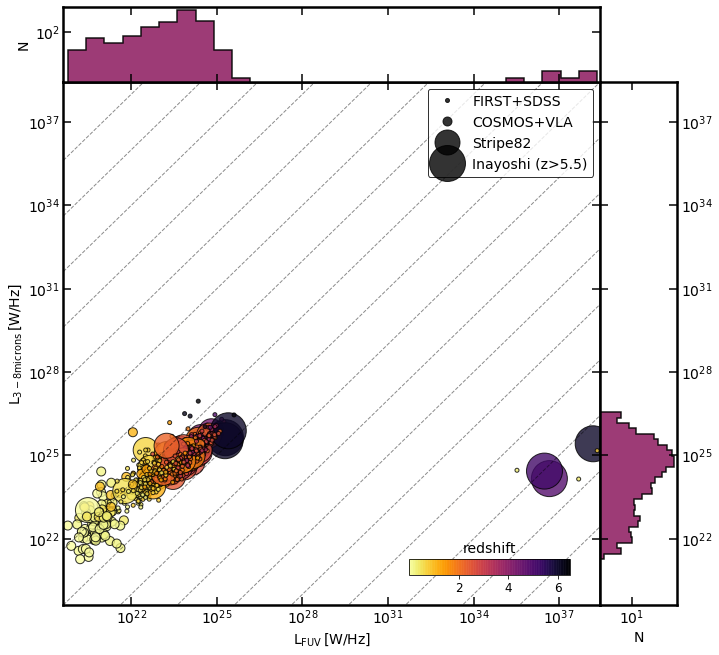

In [53]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity FUV"
col_b         = "Luminosity 3-8 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

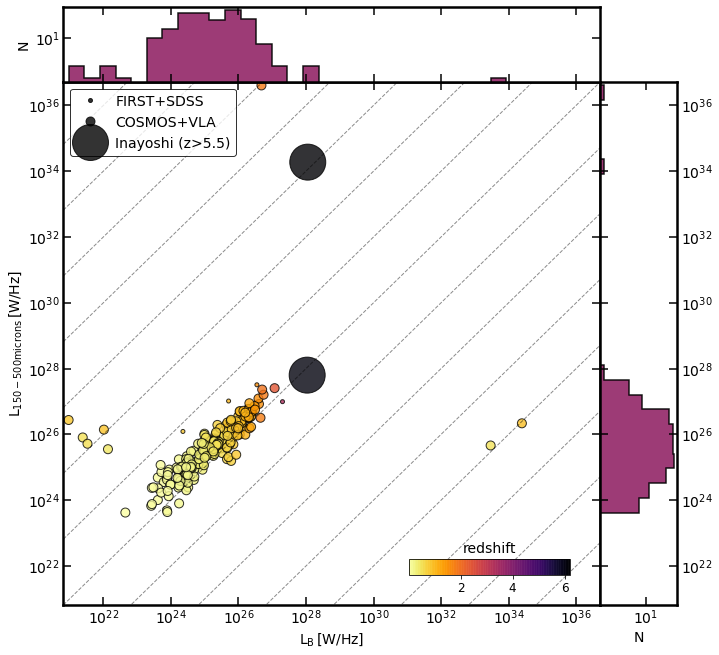

In [54]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity B"
col_b         = "Luminosity 150-500 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

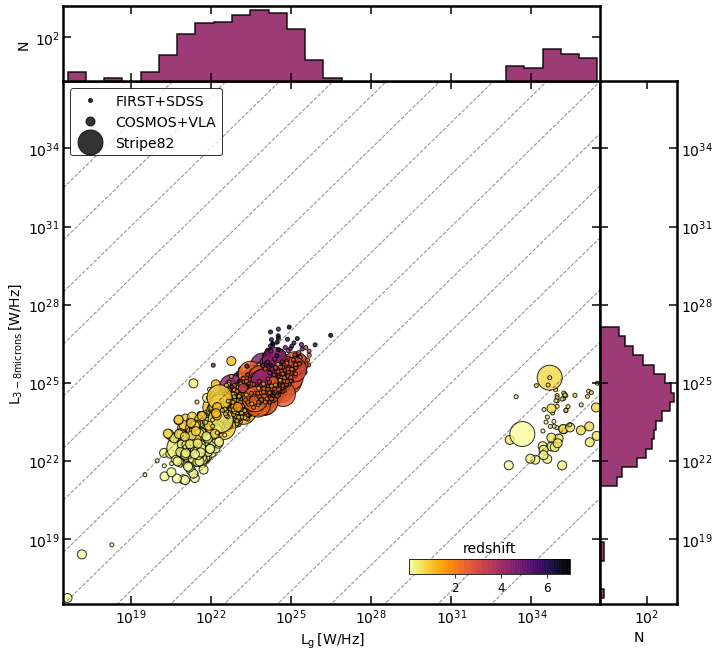

In [55]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity g"
col_b         = "Luminosity 3-8 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

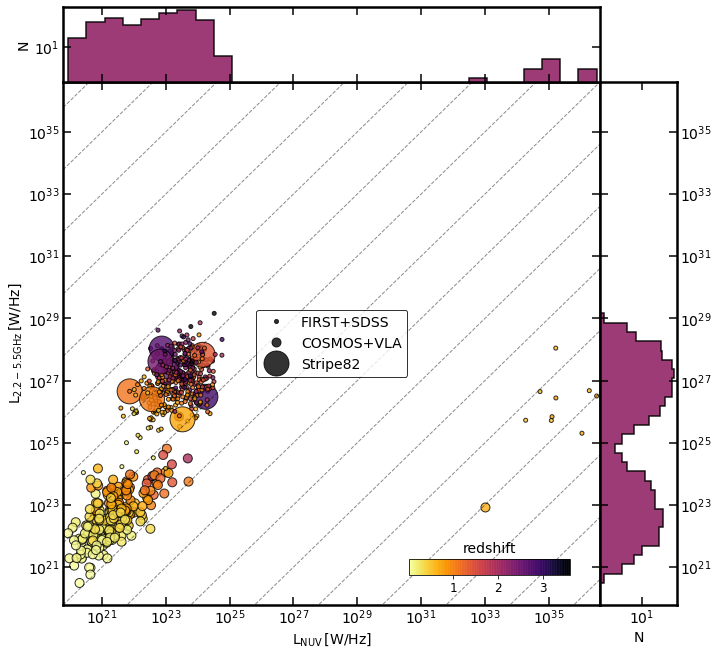

In [56]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity NUV"
col_b         = "Luminosity 2.2-5.5 GHz"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

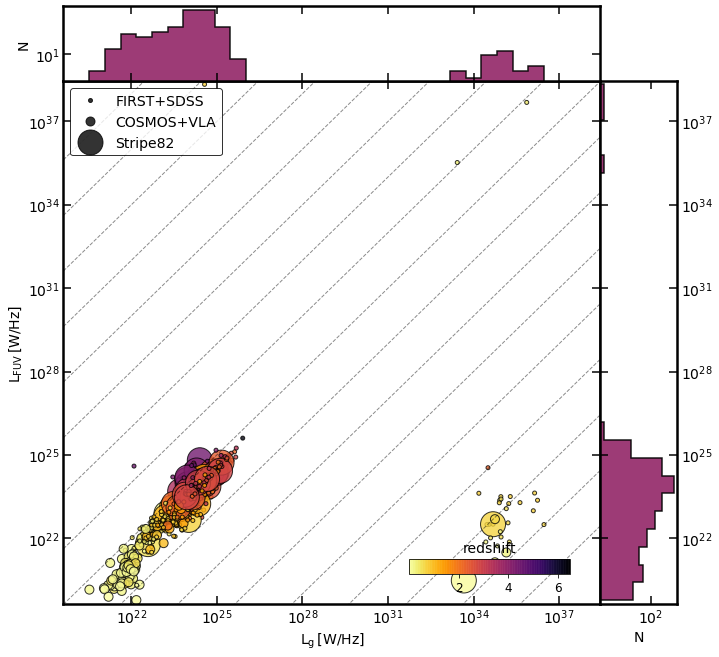

In [57]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity g"
col_b         = "Luminosity FUV"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

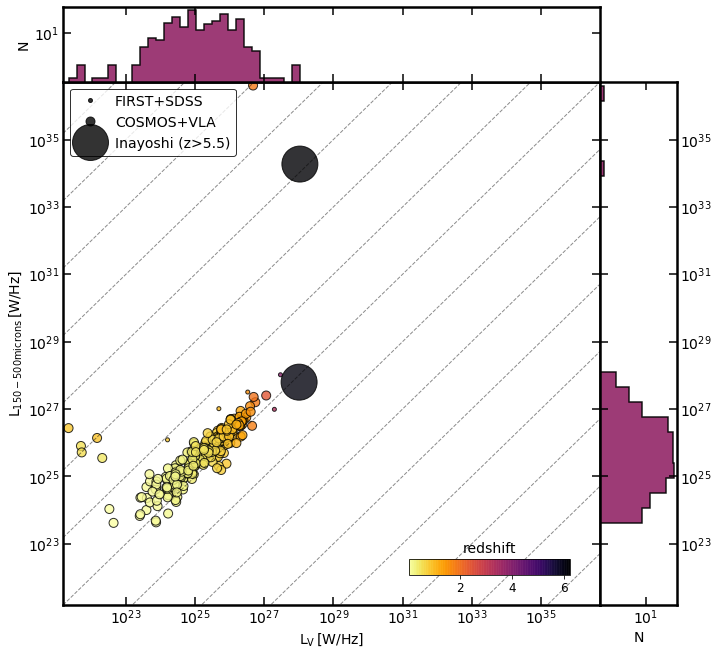

In [58]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity V"
col_b         = "Luminosity 150-500 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

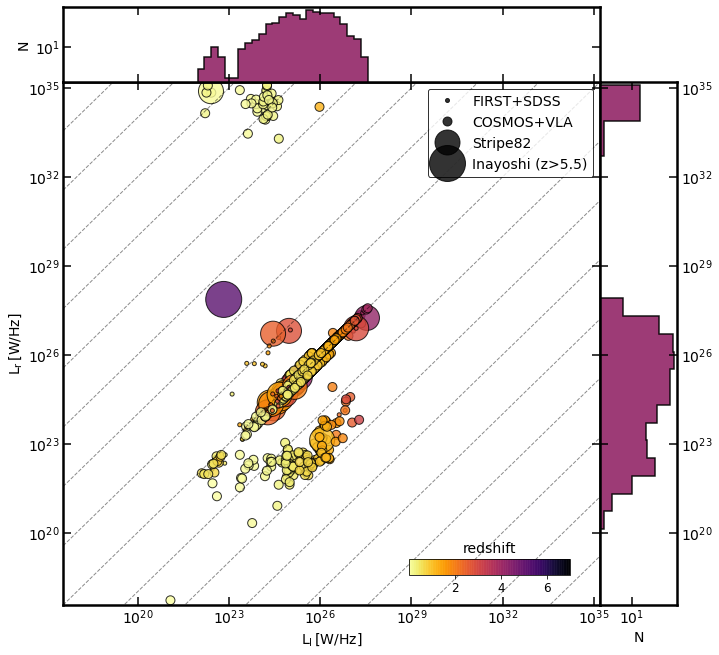

In [59]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity I"
col_b         = "Luminosity r"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

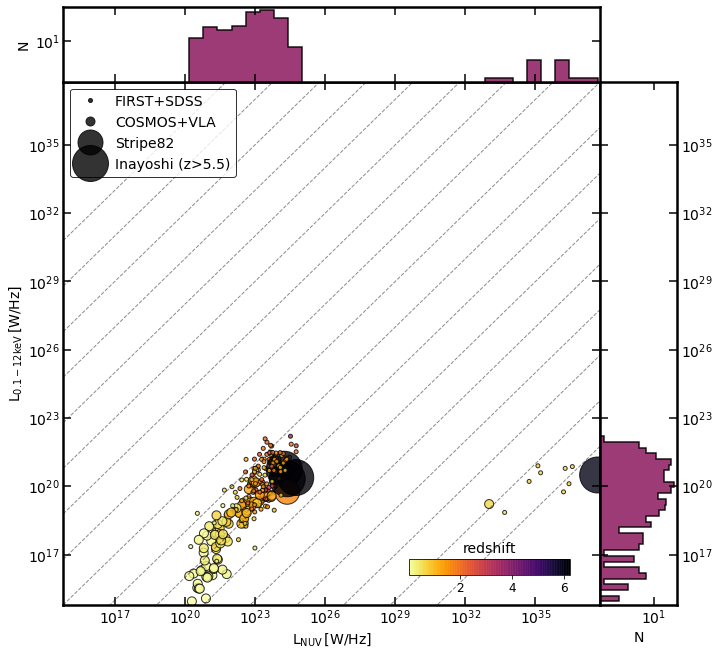

In [60]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity NUV"
col_b         = "Luminosity 0.1-12 keV"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

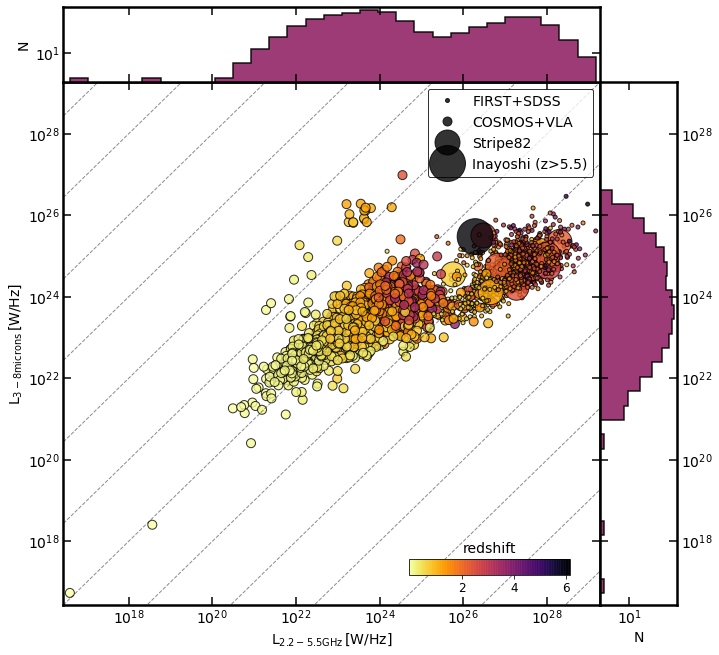

In [61]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity 2.2-5.5 GHz"
col_b         = "Luminosity 3-8 microns"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)

---

# Generate SED plot for individual sources

In [62]:
np.unique(counts_df.values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [63]:
source_idx = np.where(counts_df.values == np.nanmax(counts_df.values))[0][0]
#source_idx = 33
source_z   = redshift_df.iloc[source_idx]

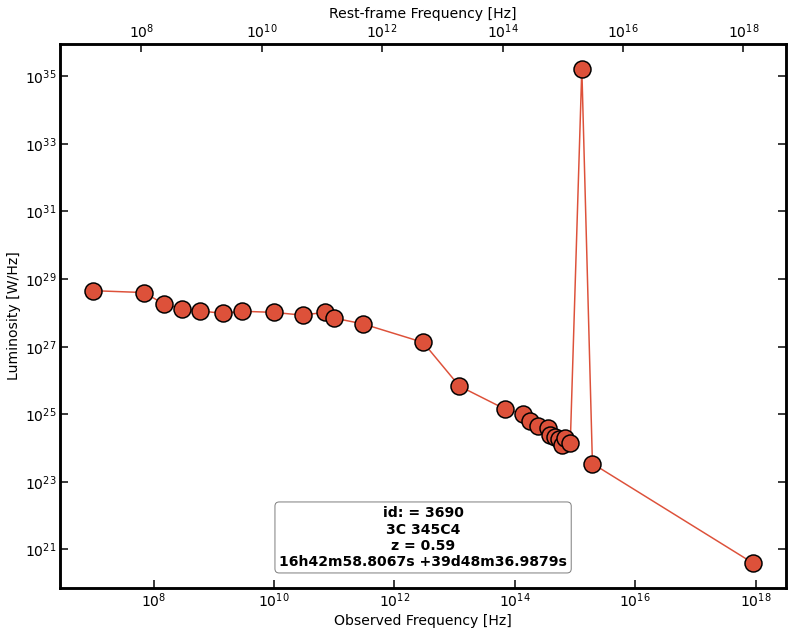

In [64]:
fig        = plt.figure(figsize=(13,10))
ax1        = fig.add_subplot(111)

plot_sed_source(source_idx, source_z, ax1)